In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [12]:
import math

a = 1000.05624604543e-3
b = 10.6068254211646e-3

f1 = 0.0e-3
f2 = f1 + 2.0 * math.sqrt(a * a + b * b)

# parabola part
p = 0.0562460454334836e-3

# whole mirror
WD = 1902.50110774383e-3
ML = 200.0e-3

param1 = 1.0 / (a * a)
param2 = -(f1 + f2) / (a * a) + 4.0 * p / (b * b)
param3 = math.pow(f1 + f2, 2) / (4.0 * a * a) - 4.0 * p * (p + f2) / (b * b) - 1.0
seam = (-param2 - math.sqrt(param2**2 - 4.0 * param1 * param3)) / (2.0 * param1)

def parabola(z):
    return math.sqrt(-4.0 * p * (z - p - f2))
def hyperbola(z):
    return b * math.sqrt((z - (f1 + f2) / 2)**2 / a**2 - 1.0)

entrance_radius = parabola(f1 - WD - ML)
seam_radius = parabola(seam)
exit_radius = hyperbola(f1 - WD)
ring_radius = seam_radius * WD / (f1 - seam)

In [13]:
# 1秒角分解能とは
# 上流端の光軸点から焦点面で見込む角度の分解能が1秒

resolution_deg = 1.0 / 3600
resolution_rad = resolution_deg / 180 * math.pi

required_beam_radius = (ML + WD) * math.tan(resolution_rad)

print(required_beam_radius)

print(math.atan2(38.2e-9, ML + WD) / math.pi * 180 * 3600)

1.0193213015901495e-05
0.0037475916514946726


In [72]:
# 理想集光

class IdealFocusSimulator():

    def __init__(self, wavelength, exit_length, N):
        self.wavelength = wavelength
        self.exit_length = exit_length
        self.N = N
        self.detector_length = N * WD * wavelength / exit_length
    
    def getIdealFocus(self):

        x = np.linspace(-0.5 * self.exit_length, 0.5 * self.exit_length, self.N)
        y = x.copy()
        x, y = np.meshgrid(x, y)

        ring = np.zeros((N, N))

        r = np.hypot(x, y)
        ring[(ring_radius <= r) & (r <= exit_radius)] = 1.0

        focus = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(ring)))
        return focus / np.sum(np.abs(focus))

    def getFWHM(self):
        x = np.linspace(-0.5 * self.detector_length, 0.5 * self.detector_length, self.N)
        focus_max = np.max(focus_profile)
        diff = focus_profile - 0.5 * focus_max

        min_index = np.argmin(np.abs(diff))
        return 2.0 * abs(x[min_index])
    
    def getHPD(self):
        x = np.linspace(-0.5 * self.detector_length, 0.5 * self.detector_length, self.N)
        y = x.copy()
        x, y = np.meshgrid(x, y)
        r = np.hypot(x, y)

        whole_sum = np.sum(np.abs(focus))

        hpd = 0.5 * self.detector_length
        step = hpd
        while True:
            ratio = np.sum(np.abs(focus[r <= 0.5 * hpd])) / whole_sum
            step /= 2
            if step < self.detector_length / self.N:
                break
            if ratio > 0.5:
                hpd -= step
            else:
                hpd += step

        return hpd

FWHM: 6.249969673445543e-05
HPD: 0.03301261142026221


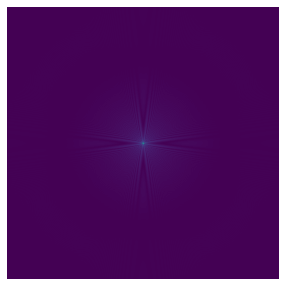

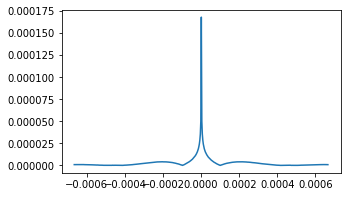

In [79]:
# 可視光

N = 4096

wavelength = 632.8e-9
exit_length = 2 * exit_radius

sim = IdealFocusSimulator(wavelength, exit_length, N)
focus = sim.getIdealFocus()
                      
K = 512
fig = plt.figure(figsize=(5, 5))
plt.axis('off')
plt.imshow(np.abs(focus[(N//2-K//2):(N//2+K//2),(N//2-K//2):(N//2+K//2)]))

fig.savefig('resource/chap2/ideal/focus_abs_visible.png')
    
focus_profile = np.abs(focus[:, N//2])

x = np.linspace(-0.5 * detector_length, 0.5 * detector_length, N)

fig = plt.figure(figsize=(5, 3))
plt.plot(x[(N//2-K//2):(N//2+K//2)], focus_profile[(N//2-K//2):(N//2+K//2)])
fig.savefig('resource/chap2/ideal/focus_profile_visible.png')

fwhm = sim.getFWHM()
print('FWHM:', fwhm)

hpd = sim.getHPD()
print('HPD:', hpd)

FWHM: 1.1905362585920912e-07
HPD: 2.883795054503528e-05
FWHM: 3.57160877577607e-08
HPD: 8.651385163510583e-06
FWHM: 7.1432175515521404e-09
HPD: 1.730277032702117e-06


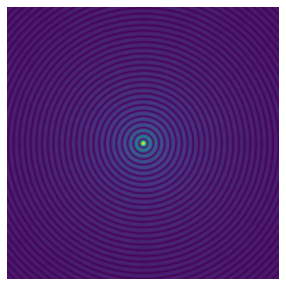

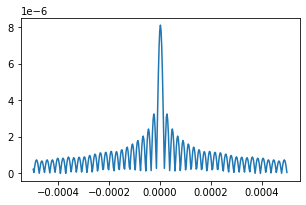

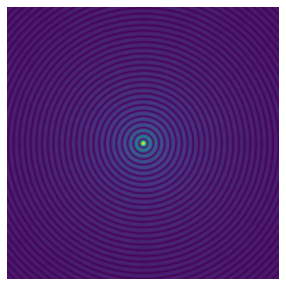

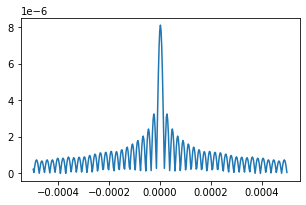

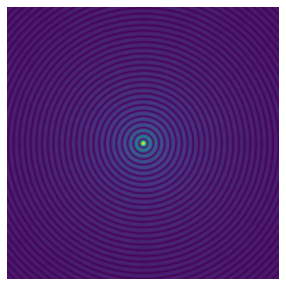

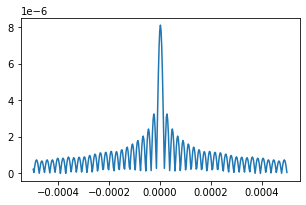

In [71]:
# 300eV

N = 4096

for energy, name in zip([0.3, 1.0, 5.0], ['300eV', '1keV', '5keV']):

    wavelength = 1.23984 / energy * 1.0e-9
    exit_length = 16 * exit_radius

    sim = IdealFocusSimulator(wavelength, exit_length, N)
    focus = sim.getIdealFocus()

    K = 2*abs(N//2 - np.argmin(np.abs(x - 500.0e-6)))
    fig = plt.figure(figsize=(5, 5))
    plt.axis('off')
    plt.imshow(np.abs(focus[(N//2-K//2):(N//2+K//2),(N//2-K//2):(N//2+K//2)]))

    fig.savefig('../thesis/chap2/figure/ideal/focus_abs_' + name + '.png')

    focus_profile = np.abs(focus[:, N//2])
    x = np.linspace(-0.5 * detector_length, 0.5 * detector_length, N)
    window = (-500.0e-6 < x) & (x < 500.0e-6)

    fig = plt.figure(figsize=(5, 3))
    plt.plot(x[window], focus_profile[window])
    fig.savefig('../thesis/chap2/figure/ideal/focus_profile_' + name + '.png')

    fwhm = sim.getFWHM()
    print('FWHM:', fwhm)

    hpd = sim.getHPD()
    print('HPD:', hpd)